## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Загрузка данных и импорт библиотек 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.cluster import KMeans
import datasist as ds

#модели
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
#!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import SCORERS, roc_auc_score, roc_curve,  accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [2]:
contract = pd.read_csv('datasets/contract.csv')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
personal = pd.read_csv('datasets/personal.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [4]:
internet = pd.read_csv('datasets/internet.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
phone = pd.read_csv('datasets/phone.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Объединим все датасеты в один по полю customerID

In [6]:
df= personal.merge(phone, how ='outer', on='customerID').merge(internet,how ='outer', on='customerID').merge(contract,how ='outer', on='customerID')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,Female,0,Yes,Yes,NaN,DSL,Yes,No,No,No,No,No,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


## Первичный анализ, преобразование типов, выделение целевой переменной 

In [7]:
display(df.shape)
df.info()

(7043, 20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Преобразуем в float и восстановим значения исходя из MonthlyCharges и Type

In [9]:
df['MonthlyCharges']=pd.to_numeric(df['MonthlyCharges'], downcast='float')
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce', downcast='float')

df.loc[df['TotalCharges'].isna(),'Type'].unique()

array(['Two year', 'One year'], dtype=object)

In [10]:
df['TotalCharges']=df['TotalCharges'].fillna(df['MonthlyCharges']*12 if df['Type'].str.split(' ')[0]=='One' else df['MonthlyCharges']*24)
df['TotalCharges'].isna().sum()

0

### Разделение переменных по типам


In [11]:
bin_features  =['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                'PaperlessBilling'] # бинарные
cat_features  =['Type','PaymentMethod', 'InternetService'] #категориальные
date_features =['BeginDate','EndDate','ActDate'] #даты
num_features  =['MonthlyCharges', 'TotalCharges'] # числовые 

In [12]:
df['InternetService']=df['InternetService'].fillna('No Internet')

In [13]:
df[bin_features+cat_features]=df[bin_features+cat_features].fillna('No')

Добавим столбец с датой актуальности

In [14]:
ACT_DATE = '2020-02-01'
df['ActDate']=df['EndDate'].where(df['EndDate']!='No',ACT_DATE)

Преобразуем даты 

In [15]:
for feature in date_features:
    df[feature]=pd.to_datetime(df[feature],format='%Y-%m-%d', errors='coerce')
df[date_features].info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   BeginDate  7043 non-null   datetime64[ns]
 1   EndDate    1869 non-null   datetime64[ns]
 2   ActDate    7043 non-null   datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 478.1 KB


Сделаем копию датасета, чтобы не потерять изначальные данные

In [16]:
df_backup=df.copy()

### Целевая переменная и анализ 

Выделим целевую переменную Left (1 - клиент расторгнул договор, 0 - действующий клиент) и посмотрим ее распределение

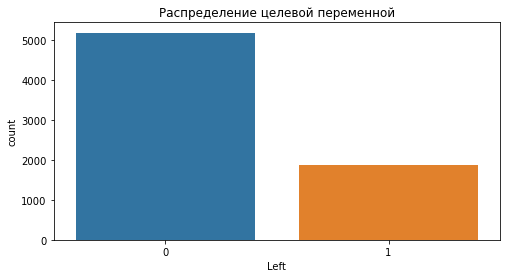

In [17]:
df['Left']=df['EndDate'].notnull().astype('int')
plt.figure(figsize=(8, 4))
sns.countplot(df['Left'])
plt.title(f"Распределение целевой переменной");

Вывод: большая честь клиентов все таки остается у оператора, но перекос значительный.

### Категориальные переменные 

Посмотрим на распределение категориальных переменных с учетом целевой

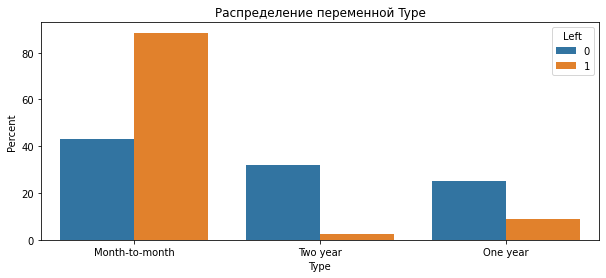

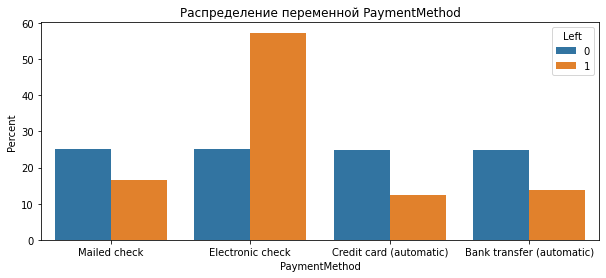

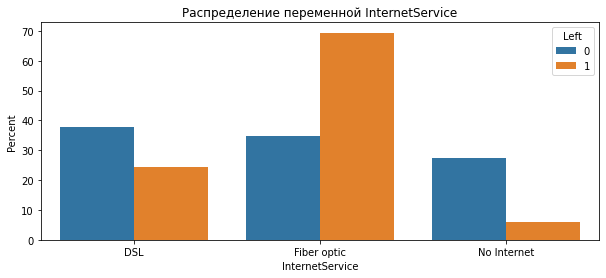

In [18]:
for feature in cat_features:
    plt.figure(figsize=(10, 4))
    prop_df = df[feature].groupby(df["Left"]).value_counts(normalize=True).rename("Percent").reset_index()
    prop_df["Percent"] *= 100
    sns.barplot(x=feature, y="Percent", hue="Left", data=prop_df)
    plt.title(f"Распределение переменной {feature}")

Вывод: в группе риска клиенты, оплачивающие услуги оптики ежемесячно, пользующиеся электронными чеками. В принципе довольно очевидно, каждый раз нажимая кнопку оплаты есть возможность обдумать стоит ли. InternetService DSL довольно старая технология с низкой скоростью, большая доля вероятности, что в данной местности просто нет еще операторов готовых предложить Fiber optic и уходить просто некуда.

### Бинарные переменные 

Добавим дополнительный признак trial, когда пользователь оплатил только 1 месяц

In [19]:
df['Trial']=(df['MonthlyCharges']==df['TotalCharges']).astype('int')

Посмотрим на распределение бинарных переменных с учетов целевой

In [20]:
bin_features=bin_features+['Trial']
bin_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'Trial']

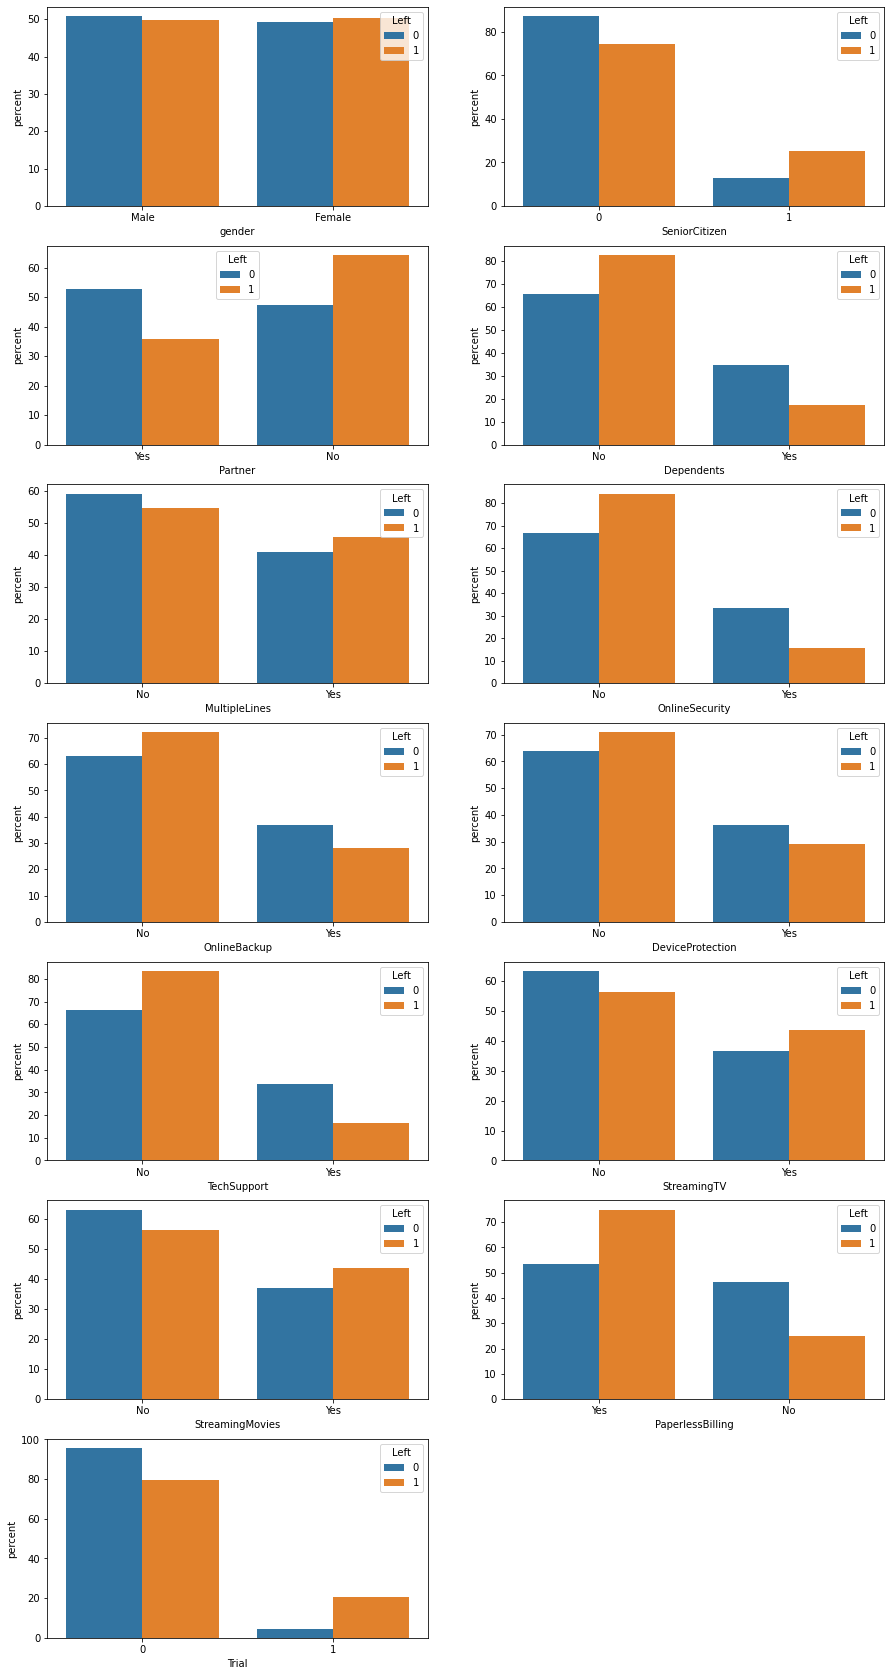

In [21]:
fig = plt.figure(1, figsize=(15,30)) 
for i,feature in enumerate(bin_features):
    plt.subplot(7,2,i+1)
    prop_df = df[feature].groupby(df["Left"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=feature, y="percent", hue="Left", data=prop_df)


Вывод: gender оказывает низкое влияние на целевую переменную, в отличии от остальных признаков, например если человек не пользуется услугой TechSupport можно сделать предполложение, что он технически подкован и с легкостью может поменять оператора, перейдя на более выгодные условия.  PaperlessBilling и онлайн оплата - призыв отказаться от бумажных чеков, что говорит о более "современных" пользователях, которые более склонны к изменениям, возраст мог бы подтвердить или опровергнуть данную гиоптезу.


### Перекодировка 

Перекодируем категориальные признаки

In [22]:
oh_features=pd.get_dummies(df[bin_features+cat_features], drop_first=True)
df=df.drop(columns=bin_features+cat_features)
df=df.join(oh_features)


In [23]:
df.head()

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,ActDate,Left,SeniorCitizen,Trial,gender_Male,...,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No Internet
0,7590-VHVEG,2020-01-01,NaT,29.850000,29.850000,2020-02-01,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,5575-GNVDE,2017-04-01,NaT,56.950001,1889.500000,2020-02-01,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,53.849998,108.150002,2019-12-01,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,7795-CFOCW,2016-05-01,NaT,42.299999,1840.750000,2020-02-01,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,70.699997,151.649994,2019-11-01,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


Определим значимость категориальных и бинарных признаков

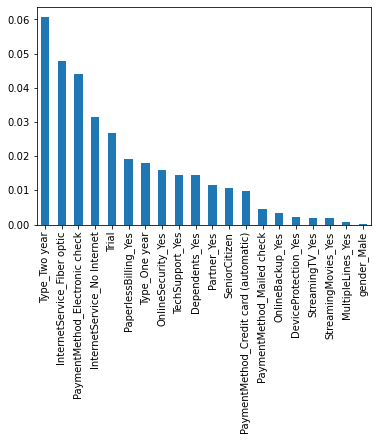

In [24]:
imp_cat = pd.Series(mutual_info_classif(df[oh_features.columns], df["Left"],
                                        discrete_features=True), index=oh_features.columns)
imp_cat.sort_values(inplace=True, ascending=False)
imp_cat.plot(kind="bar");

Вывод: Возможно gender можно исключить, т.к. влияние очень низкое. DeviceProtection StreamingTV, StreamingMovies, MultipleLines под вопросом, я бы проверил на кроссвалидации с ними и без.

### Количественные переменные

#### Распределение количественных переменных

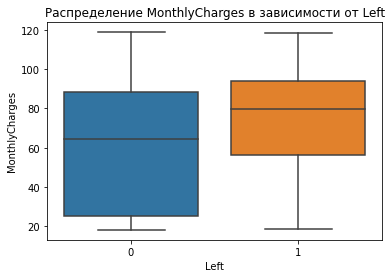

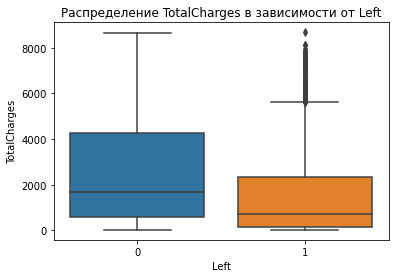

In [25]:
for feature in num_features:
    plt.figure()
    plt.title(f"Распределение {feature} в зависимости от Left")
    sns.boxplot("Left", feature, data=df)

Вывод: если смотреть на ежемесячную оплату, но можно сказать что те кто платил большую сумму в месяц сменил оператора.

#### Добавление признаков

Добавим еще один признак "длительность пользования оператором" durationUse

In [26]:
df['durationUse']=(df['ActDate']-df['BeginDate']).dt.days
np.sort(df['durationUse'].unique())

array([   0,   30,   31,   61,   62,   91,   92,  122,  123,  153,  183,
        184,  214,  215,  242,  244,  245,  273,  275,  276,  303,  304,
        306,  334,  335,  337,  365,  395,  396,  426,  427,  456,  457,
        487,  488,  518,  548,  549,  579,  580,  607,  609,  610,  638,
        640,  641,  668,  669,  671,  699,  700,  702,  730,  760,  761,
        791,  792,  821,  822,  852,  853,  883,  913,  914,  944,  945,
        972,  974,  975, 1003, 1005, 1006, 1033, 1034, 1036, 1064, 1065,
       1067, 1095, 1125, 1126, 1156, 1157, 1186, 1187, 1217, 1218, 1248,
       1278, 1279, 1309, 1310, 1338, 1340, 1369, 1370, 1371, 1399, 1400,
       1401, 1430, 1431, 1432, 1461, 1491, 1492, 1522, 1523, 1552, 1553,
       1583, 1584, 1614, 1644, 1645, 1675, 1676, 1703, 1705, 1706, 1734,
       1736, 1737, 1764, 1765, 1767, 1795, 1796, 1798, 1826, 1856, 1857,
       1887, 1888, 1917, 1918, 1948, 1949, 1979, 2009, 2010, 2040, 2041,
       2068, 2070, 2071, 2099, 2101, 2102, 2129, 21

<AxesSubplot:xlabel='durationUse', ylabel='Density'>

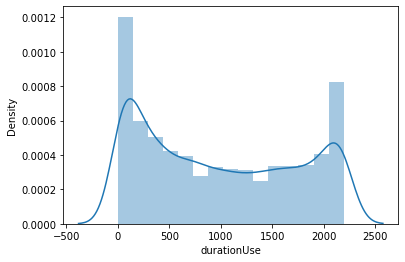

In [27]:
sns.distplot(df['durationUse'])

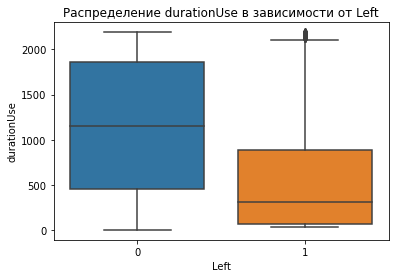

In [28]:
plt.figure()
plt.title(f"Распределение durationUse в зависимости от Left")
sns.boxplot("Left", 'durationUse', data=df);

Вывод: тут все очеведно, чем дольше пользователь у оператора, тем больше его лояльность. 

### Портрет самого ценного клиента

А сколько в среднем платят клиенты, потребляющие разные услуги

In [29]:
df_backup=df_backup.join(df[['durationUse','Left']])

,MonthlyCharges,durationUse,TotalCharge
InternetService,,,
DSL,49.083225,429.616558,702.898876
Fiber optic,88.126488,614.851195,1806.155877
No Internet,20.368141,250.840708,170.305298


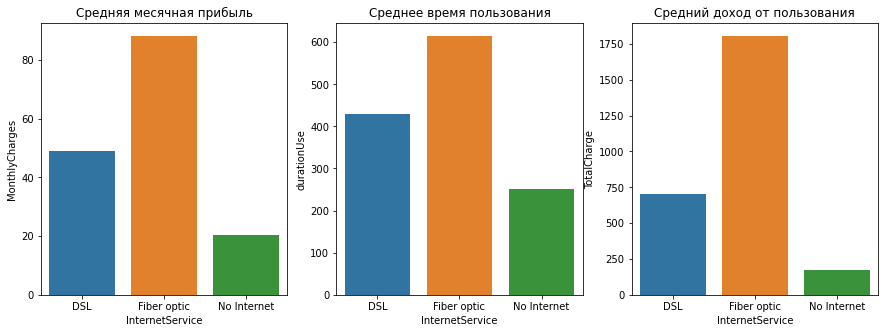

In [30]:
data=pd.DataFrame(df_backup[df_backup['Left']==1].groupby('InternetService')['MonthlyCharges','durationUse'].mean())
data['TotalCharge']=data['MonthlyCharges']*data['durationUse']/30
display(data)
fig,ax =plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=data, x=data.index, y='MonthlyCharges',ax=ax[0]);
ax[0].set_title('Средняя месячная прибыль')
sns.barplot(data=data, x=data.index, y='durationUse', ax=ax[1]);
ax[1].set_title('Среднее время пользования')
sns.barplot(data=data, x=data.index, y='TotalCharge', ax=ax[2]);
ax[2].set_title('Средний доход от пользования');

Самые ценные клиенты, которые пользуются оптикой, с них самый большой средний доход и им прежде всего надо предлагать бонусы.

,MonthlyCharges,durationUse,TotalCharge
Type,,,
Month-to-month,86.473320,495.516351,1428.298133
One year,101.653366,1564.615385,5301.614016
Two year,104.712906,1901.677419,6637.672288


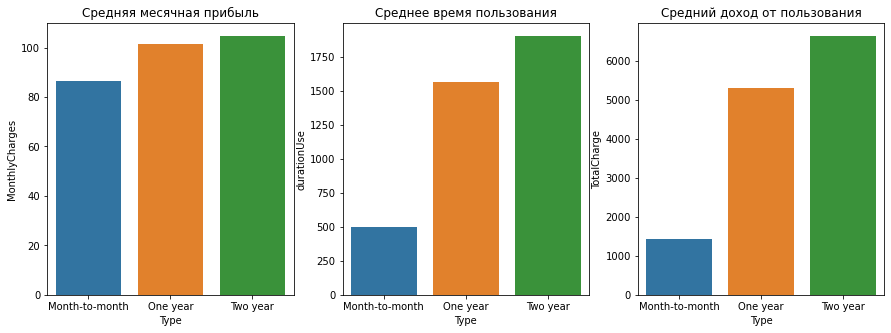

In [31]:
data=df_backup[(df_backup['InternetService']=='Fiber optic')&(df_backup['Left']==1)].groupby('Type')['MonthlyCharges','durationUse'].mean()
data['TotalCharge']=data['MonthlyCharges']*data['durationUse']/30
display(data)
fig,ax =plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=data, x=data.index, y='MonthlyCharges',ax=ax[0]);
ax[0].set_title('Средняя месячная прибыль')
sns.barplot(data=data, x=data.index, y='durationUse', ax=ax[1]);
ax[1].set_title('Среднее время пользования')
sns.barplot(data=data, x=data.index, y='TotalCharge', ax=ax[2]);
ax[2].set_title('Средний доход от пользования');

И что очевидно если он платит на много месяцев, а лучше лет вперед.

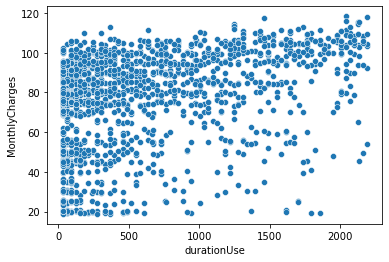

In [32]:
sns.scatterplot(data=df_backup[df_backup['Left']==1], x='durationUse', y='MonthlyCharges');

Также интересно, что наблюдается большое количество людей, которые уходят в первые месяцы использования оплачивая дорогие услуги.

#### Корреляция признаков

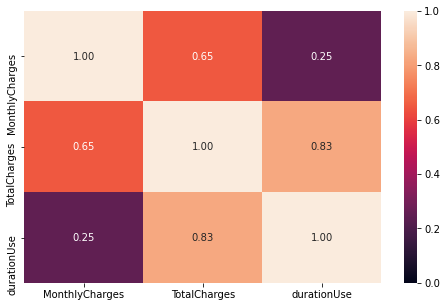

In [33]:
plt.figure(figsize=(8, 5))
sns.heatmap(df[num_features+['durationUse']].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f");

Вывод: Чем дольше пользуется и больше платит, тем больше общая сумма. Для построения модели я бы убрал TotalCharges как сильно коррелирующей.

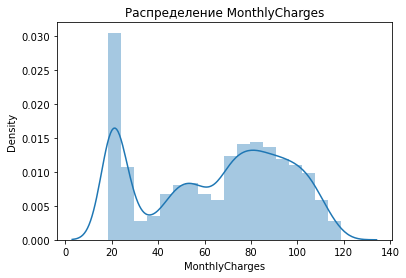

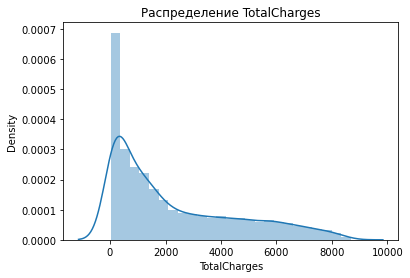

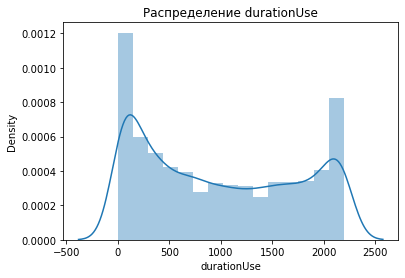

In [34]:
for feature in num_features+['durationUse']:
    plt.figure()
    plt.title(f"Распределение {feature}")
    sns.distplot(df[feature], kde=True)

Выводы: Исходя из распределений, есть большое количество новопришедших пользователей, которые только подключились, либо кто попробовал и ушел. По продолжительности использования и месячной оплате получилось бимодальное распределение, что наверное не так плохо для бинарной классификации.

#### Дисперсионный анализ ANOVA для определения значимости числовых признаков

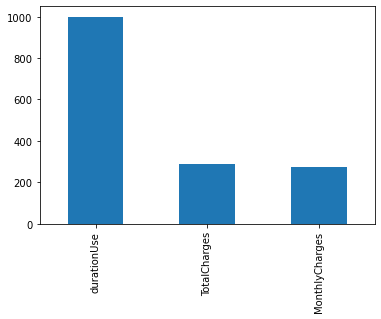

In [35]:
imp_num = pd.Series(f_classif(df[num_features+['durationUse']], df["Left"])[0], index=num_features+['durationUse'])
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar");

Вывод: наиболее значимым оказался новый признак с длительность пользования услугами оператора.

## Подготовка признаков 

In [36]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges',
       'ActDate', 'Left', 'SeniorCitizen', 'Trial', 'gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'MultipleLines_Yes',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'PaperlessBilling_Yes', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No Internet',
       'durationUse'],
      dtype='object')

### Инсайты 

Выделим группы по MonthlyCharges и durationUse и добвим их как дополнительные признаки

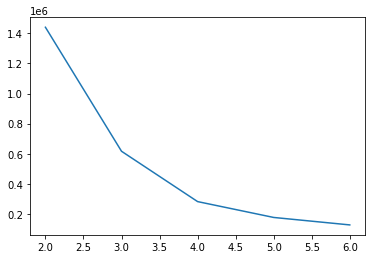

In [37]:
RANDOM_STATE = 18112021
points = []
K = range(2,7,1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(df['MonthlyCharges'].values.reshape(-1, 1))
    points.append(kmeans.inertia_)
sns.lineplot(x=K, y=points);



In [38]:
df=df.assign(mcCluster=KMeans(n_clusters=4, random_state=RANDOM_STATE).fit_predict(df['MonthlyCharges'].values.reshape(-1, 1)))


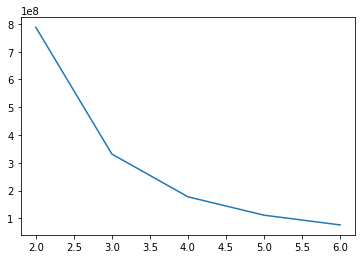

In [39]:
points = []
K = range(2,7,1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(df['durationUse'].values.reshape(-1, 1))
    points.append(kmeans.inertia_)
sns.lineplot(x=K, y=points);



In [40]:
df=df.assign(duCluster=KMeans(n_clusters=4, random_state=RANDOM_STATE).fit_predict(df['durationUse'].values.reshape(-1, 1)))
df.head()

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,ActDate,Left,SeniorCitizen,Trial,gender_Male,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No Internet,durationUse,mcCluster,duCluster
0,7590-VHVEG,2020-01-01,NaT,29.850000,29.850000,2020-02-01,0,0,1,0,...,0,0,0,1,0,0,0,31,0,3
1,5575-GNVDE,2017-04-01,NaT,56.950001,1889.500000,2020-02-01,0,0,0,1,...,1,0,0,0,1,0,0,1036,2,1
2,3668-QPYBK,2019-10-01,2019-12-01,53.849998,108.150002,2019-12-01,1,0,0,1,...,0,0,0,0,1,0,0,61,2,3
3,7795-CFOCW,2016-05-01,NaT,42.299999,1840.750000,2020-02-01,0,0,0,1,...,1,0,0,0,0,0,0,1371,2,2
4,9237-HQITU,2019-09-01,2019-11-01,70.699997,151.649994,2019-11-01,1,0,0,0,...,0,0,0,1,0,1,0,61,1,3


Уберем даты, т.к. они сильно коррелированы с durationUse и будут являться leak-ом при совместном использовании, TotalCharges, customerID как идентификатор.

In [41]:
df=df.drop(columns=['BeginDate','EndDate','ActDate','customerID','TotalCharges'])
df.head()

,MonthlyCharges,Left,SeniorCitizen,Trial,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No Internet,durationUse,mcCluster,duCluster
0,29.850000,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,31,0,3
1,56.950001,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1036,2,1
2,53.849998,1,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,0,61,2,3
3,42.299999,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1371,2,2
4,70.699997,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,61,1,3


Разделим датасет на train и test

In [42]:

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Left'), df['Left'],test_size=0.2, 
                                                   random_state=RANDOM_STATE, stratify=df['Left'], shuffle=True)

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
y_test.shape

(5634, 24)

(5634,)

(1409, 24)

(1409,)

In [43]:
X_train

,MonthlyCharges,SeniorCitizen,Trial,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No Internet,durationUse,mcCluster,duCluster
2602,111.449997,0,0,0,1,1,1,0,1,1,...,1,0,0,1,0,1,0,1949,3,0
3464,83.849998,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,945,1,1
2841,25.100000,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,92,0,3
327,70.349998,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,61,1,3
4219,75.150002,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,0,1461,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,65.550003,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,123,1,3
979,54.950001,0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1067,2,1
3515,55.500000,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,518,2,1
724,94.500000,1,0,1,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1003,3,1


### Выбор модели

In [44]:

CLASS_WEIGHT = 'balanced'
models=[DummyClassifier(strategy='stratified', random_state=RANDOM_STATE),
        LogisticRegression(random_state=RANDOM_STATE, class_weight=CLASS_WEIGHT),
        LinearDiscriminantAnalysis(),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=RANDOM_STATE, class_weight=CLASS_WEIGHT),
        SVC(random_state=RANDOM_STATE, class_weight=CLASS_WEIGHT),
        GradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=3),
        XGBClassifier(verbosity=0, random_state=RANDOM_STATE, max_depth=3 ),
        CatBoostClassifier(verbose=0, random_state=RANDOM_STATE, max_depth=3),
        LGBMClassifier(verbose=-1, random_state=RANDOM_STATE)]

In [45]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [46]:
def getModesScore(models, X, y):
    def _modelName(model):
        try:
            return str(model).split('(')[0].split('.')[2].split()[0]
        except:
            return str(model).split('(')[0]
    skf = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    results =pd.DataFrame()
    for model in tqdm(models):
        cv=cross_validate(model, X, y, scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1'], cv=skf.split(X,y))
        results=pd.concat([results,pd.DataFrame(cv).assign(model=_modelName(model))])
    return results    
results=getModesScore(models, X_train,y_train)        
        

100%|██████████████████████████████████████████| 10/10 [00:36<00:00,  3.64s/it]


In [47]:
results.groupby('model').mean().sort_values(by='test_roc_auc', ascending=False)

,fit_time,score_time,test_roc_auc,test_accuracy,test_recall,test_precision,test_f1
model,,,,,,,
XGBClassifier,0.313684,0.029335,0.888636,0.850018,0.616729,0.772698,0.685905
CatBoostClassifier,4.381253,0.025667,0.887798,0.844870,0.578599,0.780317,0.664426
LGBMClassifier,0.135340,0.032335,0.883813,0.842918,0.612034,0.750331,0.674087
GradientBoostingClassifier,0.798713,0.025334,0.880514,0.837948,0.583280,0.751401,0.656383
LogisticRegression,0.219680,0.045668,0.844406,0.742102,0.795991,0.509048,0.620963
LinearDiscriminantAnalysis,0.056002,0.021001,0.842088,0.803159,0.539809,0.658052,0.592848
RandomForestClassifier,0.952054,0.158009,0.840148,0.812567,0.519064,0.698139,0.595243
SVC,1.809772,1.815769,0.786427,0.701100,0.700323,0.458817,0.554312
KNeighborsClassifier,0.014667,1.230738,0.780079,0.783458,0.482950,0.618450,0.542098


Лучшей моделью по результатам теста оказался XGBClassifier, из простых моделей LogisticRegression показала неплохой результат.

### Подбор гиперпараметров

Применим StratifiedKFold и GridSearchCV к XGBClassifier и LogisticRegression

In [48]:
lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
xgb= XGBClassifier(random_state=RANDOM_STATE, max_depth=3)

In [49]:
lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [50]:
lr_params = {
        'C': range(1,5,1),
        'penalty': ['l1','l2','elasticnet'],
        'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
        }
skf = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
gscv_lr = GridSearchCV(lr, param_grid=lr_params, cv=skf.split(X_train, y_train), scoring='roc_auc', verbose=1)
gscv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000071407DEE40>,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=18112021),
             param_grid={'C': range(1, 5),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             scoring='roc_auc', verbose=1)

Лучший результат и параметры

In [51]:
display(gscv_lr.best_params_)
display(gscv_lr.best_score_)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

0.8459353961514617

In [52]:
xgb.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [53]:
xgb_params={
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [2, 3 , 5 , 7],
            'n_estimators':  range(10,150,10),
            'nthread': [4]}
xgb_gbc = GridSearchCV(xgb, param_grid=xgb_params, cv=skf.split(X_train, y_train), scoring='roc_auc', verbose=1)
xgb_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000000713FF65430>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_w...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=18112021, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                     

Лучший результат и параметры

In [54]:
display(xgb_gbc.best_params_)
display(xgb_gbc.best_score_)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 140, 'nthread': 4}

0.8997038102247334

Посмотрим я на важность признаков

In [55]:
imp=pd.DataFrame({'feature_importance': xgb_gbc.best_estimator_.feature_importances_, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)   
imp

,feature_importance,feature_names
19,0.334963,InternetService_Fiber optic
20,0.142765,InternetService_No Internet
15,0.131652,Type_Two year
2,0.069077,Trial
14,0.056629,Type_One year
21,0.036392,durationUse
17,0.028258,PaymentMethod_Electronic check
13,0.019218,PaperlessBilling_Yes
6,0.017174,MultipleLines_Yes
12,0.016823,StreamingMovies_Yes


Поместим в стекинг LogisticRegression и XGBClassifier

In [56]:
vc=StackingClassifier(estimators=[('lr', gscv_lr.best_estimator_), ('gbc', xgb_gbc.best_estimator_)],  stack_method='predict_proba')
vc.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   penalty='l1',
                                                   random_state=18112021,
                                                   solver='liblinear')),
                               ('gbc',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              enable_categorical=False, gamma=0,
                                              gpu_id=-1, importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.2,
                                              max_de

Построим ROC AUC кривые для полученных моделй

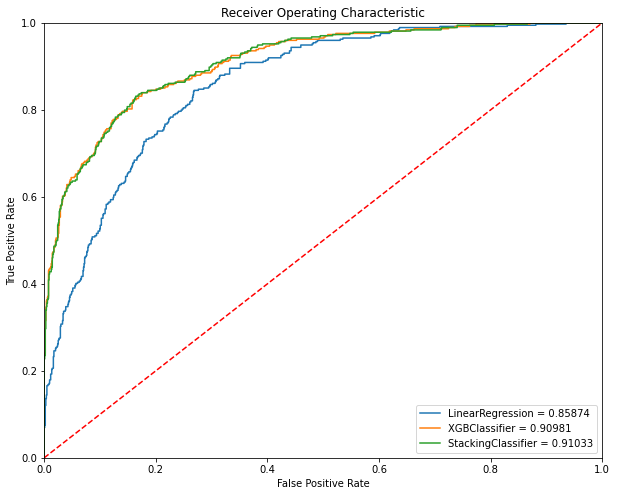

In [57]:
fpr1, tpr1, thresholds1 = roc_curve(y_test,gscv_lr.predict_proba(X_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test,xgb_gbc.predict_proba(X_test)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test,vc.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
ax=plt.plot(fpr1, tpr1,  label = 'LinearRegression = %0.5f' % roc_auc_score(y_test,gscv_lr.predict_proba(X_test)[:,1]))
ax=plt.plot(fpr2, tpr2,  label = 'XGBClassifier = %0.5f' % roc_auc_score(y_test,xgb_gbc.predict_proba(X_test)[:,1]))
ax=plt.plot(fpr3, tpr3,  label = 'StackingClassifier = %0.5f' % roc_auc_score(y_test,vc.predict_proba(X_test)[:,1]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Посмотрим на распределение в тестовом наборе и  матрицу ошибок 

In [58]:
pd.DataFrame(y_test.value_counts())

,Left
0,1035
1,374


Text(0.5, 1.0, 'StackingClassifier')

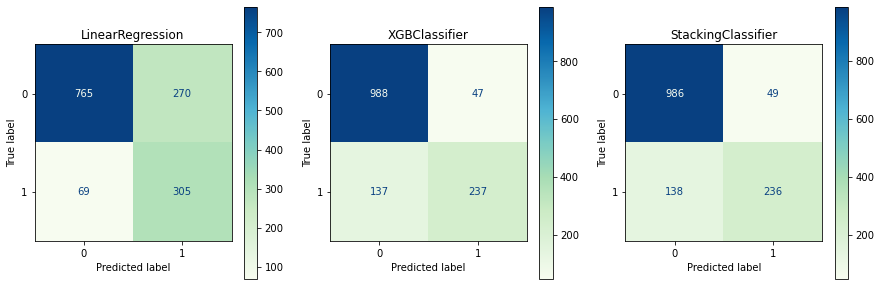

In [59]:
fig, ax= plt.subplots(1,3, figsize=(15,5))
plot_confusion_matrix(gscv_lr, X_test, y_test, ax=ax[0], cmap='GnBu'); 
ax[0].set_title('LinearRegression')
plot_confusion_matrix(xgb_gbc, X_test, y_test, ax=ax[1], cmap='GnBu'); 
ax[1].set_title('XGBClassifier')
plot_confusion_matrix(vc, X_test, y_test, ax=ax[2], cmap='GnBu'); 
ax[2].set_title('StackingClassifier')

Выводы: у линейной регрессии самое большое количество TP предсказаний, т.е. она находит много клиентов, которые  хотят уйти,  но при этом и довольно высока ошибка на FP, т.е. она заведомо большее количество людей подозревает в том что они уйдут.
XGBClassifier и стекинговая модель из линейной регрессии и XGBClassifier показали очень близкие результаты. Не смотря на уменьшение количества TP, FP у них значительно ниже.   

Посмотрим на остальные характеристики:

In [60]:
models=[gscv_lr,xgb_gbc,vc]
names =['LinearRegression','XGBClassifier','StackingClassifier']
results=[]
for idx,model in enumerate(models):
    pred=model.predict(X_test)
    pp= model.predict_proba(X_test)[:,1]
    results.append([names[idx], accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test,pp) ])

In [61]:
pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC AUC']).sort_values(by='ROC AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC AUC
2,StackingClassifier,0.867282,0.828070,0.631016,0.716237,0.910327
1,XGBClassifier,0.869411,0.834507,0.633690,0.720365,0.909805
0,LinearRegression,0.759404,0.530435,0.815508,0.642782,0.858745


Вычислим все метрики и соотношения для лучшей модели при разных thresholds, отсортируем результаты по лучшему показателю Accuracy

In [62]:
predict_proba=vc.predict_proba(X_test)
pp=predict_proba[:,1]
results=[]
for th in thresholds3:
    pred = np.where(pp>th,1,0)
    results.append([th,accuracy_score(y_test,pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred), sum(np.where((y_test==1)&(pred==1),1,0)),sum(np.where((y_test==0)&(pred==0),1,0)),sum(np.where((y_test==1)&(pred==0),1,0)),sum(np.where((y_test==0)&(pred==1),1,0))])
total=pd.DataFrame(results, columns=['Threshold','Accuracy','Precision','Recall','F1','TP','TN','FN','FP']).sort_values(by='Accuracy', ascending=False)

In [63]:
total.head()

,Threshold,Accuracy,Precision,Recall,F1,TP,TN,FN,FP
65,0.560962,0.869411,0.857143,0.609626,0.712500,228,997,146,38
63,0.568082,0.868701,0.859316,0.604278,0.709576,226,998,148,37
57,0.593564,0.868701,0.870588,0.593583,0.705882,222,1002,152,33
71,0.534868,0.868701,0.838710,0.625668,0.716692,234,990,140,45
70,0.542076,0.868701,0.841155,0.622995,0.715822,233,991,141,44


### Промокод

Возьмем условный промокод на 15%, это минимальная сумма, которая считается психологически заметной для человека.
Разобьем клиентов на 3 группы по виду используемого интернета и по типу оплаты и посчитаем потенциальный доход со следующей оплаты, допустив что условия его оплаты и тарифа не изменятся.

Таблица с разделением на 9 групп с потенциальным доходом (тратами клиента) и 15% купон на следующую оплату.

In [64]:
df_potencial=pd.DataFrame(df_backup.groupby(['Type','InternetService'])['MonthlyCharges'].mean()).reset_index()
df_potencial['PotencialCharges']=df_potencial.apply(lambda x: x['MonthlyCharges']*12 if x['Type'].split(' ')[0]=='One' else x['MonthlyCharges']*24 if x['Type'].split(' ')[0]=='Two' else x['MonthlyCharges'], axis=1)
df_potencial['Discount']=df_potencial['PotencialCharges']*0.15
df_potencial

,Type,InternetService,MonthlyCharges,PotencialCharges,Discount
0,Month-to-month,DSL,50.219501,50.219501,7.532925
1,Month-to-month,Fiber optic,87.021194,87.021194,13.053179
2,Month-to-month,No Internet,20.409542,20.409542,3.061431
3,One year,DSL,61.396755,736.761063,110.514159
4,One year,Fiber optic,98.779503,1185.354034,177.803105
5,One year,No Internet,20.819506,249.834068,37.475110
6,Two year,DSL,70.462975,1691.111389,253.666708
7,Two year,Fiber optic,104.571442,2509.714600,376.457190
8,Two year,No Internet,21.777351,522.656433,78.398465


Функции разбиения на группы тестовой выборки и получения потенциальной прибыли и скидки

In [65]:
def getClientTypePair(pType):
    df_joined= X_test.join(df_backup[['Type','InternetService']]).join(pd.Series(y_test)).join(pd.DataFrame(predict_proba, columns=['Prediction','Probability'], index=y_test.index))
    if pType==0:
        return df_joined.loc[(df_joined['Type']=='Month-to-month')&(df_joined['InternetService']=='DSL'),['Left','Prediction','Probability']]
    elif pType==1:
        return df_joined.loc[(df_joined['Type']=='Month-to-month')&(df_joined['InternetService']=='Fiber optic'),['Left','Prediction','Probability']]
    elif pType==2:
        return df_joined.loc[(df_joined['Type']=='Month-to-month')&(df_joined['InternetService']=='No Internet'),['Left','Prediction','Probability']]
    elif pType==3:
        return df_joined.loc[(df_joined['Type']=='One year')&(df_joined['InternetService']=='DSL'),['Left','Prediction','Probability']]
    elif pType==4:
        return df_joined.loc[(df_joined['Type']=='One year')&(df_joined['InternetService']=='Fiber optic'),['Left','Prediction','Probability']]
    elif pType==5:
        return df_joined.loc[(df_joined['Type']=='One year')&(df_joined['InternetService']=='No Internet'),['Left','Prediction','Probability']]
    elif pType==6:
        return df_joined.loc[(df_joined['Type']=='Two year')&(df_joined['InternetService']=='DSL'),['Left','Prediction','Probability']]
    elif pType==7:
        return df_joined.loc[(df_joined['Type']=='Two year')&(df_joined['InternetService']=='Fiber optic'),['Left','Prediction','Probability']]
    else:
        return df_joined.loc[(df_joined['Type']=='Two year')&(df_joined['InternetService']=='No Internet'),['Left','Prediction','Probability']]
def getCharges(pType):
    if pType==0:
        return df_potencial.loc[(df_potencial['Type']=='Month-to-month')&(df_potencial['InternetService']=='DSL'),['PotencialCharges','Discount']]
    elif pType==1:
        return df_potencial.loc[(df_potencial['Type']=='Month-to-month')&(df_potencial['InternetService']=='Fiber optic'),['PotencialCharges','Discount']]
    elif pType==2:
        return df_potencial.loc[(df_potencial['Type']=='Month-to-month')&(df_potencial['InternetService']=='No Internet'),['PotencialCharges','Discount']]
    elif pType==3:
        return df_potencial.loc[(df_potencial['Type']=='One year')&(df_potencial['InternetService']=='DSL'),['PotencialCharges','Discount']]
    elif pType==4:
        return df_potencial.loc[(df_potencial['Type']=='One year')&(df_potencial['InternetService']=='Fiber optic'),['PotencialCharges','Discount']]
    elif pType==5:
        return df_potencial.loc[(df_potencial['Type']=='One year')&(df_potencial['InternetService']=='No Internet'),['PotencialCharges','Discount']]
    elif pType==6:
        return df_potencial.loc[(df_potencial['Type']=='Two year')&(df_potencial['InternetService']=='DSL'),['PotencialCharges','Discount']]
    elif pType==7:
        return df_potencial.loc[(df_potencial['Type']=='Two year')&(df_potencial['InternetService']=='Fiber optic'),['PotencialCharges','Discount']]
    else:
        return df_potencial.loc[(df_potencial['Type']=='Two year')&(df_potencial['InternetService']=='No Internet'),['PotencialCharges','Discount']]

Посчитаем потенциальную прибыль при различных threshold для клиентов из каждой группы, будем выбирать только показатель максимальной прибыли.

In [67]:
df_optimal_thresholds=pd.DataFrame()
for ptype in range(0,9):
    t= getClientTypePair(ptype)['Left']
    pp= getClientTypePair(ptype)['Probability'].values
    results=[]
    for th in thresholds3[1:]:
        pred = np.where(pp>th,1,0)
        results.append([th,accuracy_score(t,pred), precision_score(t, pred), recall_score(t, pred), f1_score(t, pred), sum(np.where((t==1)&(pred==1),1,0)),sum(np.where((t==0)&(pred==0),1,0)),sum(np.where((t==1)&(pred==0),1,0)),sum(np.where((t==0)&(pred==1),1,0))])
    total=pd.DataFrame(results, columns=['Threshold','Accuracy','Precision','Recall','F1','TP','TN','FN','FP']).sort_values(by='Accuracy', ascending=False)
    pc= getCharges(ptype)['PotencialCharges'].values # потенциальная прибыль
    d=  getCharges(ptype)['Discount'].values # скидка
    total['Income'] =total['TP']*pc +total['TN']*(pc-d)-total['FN']*pc-total['FP']*d  # прибыль
    total['group']=ptype # группа, к которой относится клиент
    df_optimal_thresholds=pd.concat([df_optimal_thresholds,total.sort_values(by='Income', ascending=False).head(1)])
df_optimal_thresholds

,Threshold,Accuracy,Precision,Recall,F1,TP,TN,FN,FP,Income,group
161,0.220118,0.770492,0.593750,0.770270,0.670588,57,131,17,39,7306.937468,0
121,0.312433,0.767901,0.753623,0.888889,0.815686,208,103,26,68,22568.946783,1
176,0.195146,0.893204,0.846154,0.550000,0.666667,11,81,9,2,1439.893194,2
139,0.265196,0.921739,1.000000,0.307692,0.470588,4,102,9,0,60193.378816,3
134,0.274217,0.852174,0.642857,0.428571,0.514286,9,89,12,5,85226.955075,4
63,0.563806,0.985294,1.000000,0.500000,0.666667,1,66,1,0,14015.691232,5
0,0.952327,0.992126,0.000000,0.000000,0.000000,0,126,1,0,179426.918390,6
0,0.952327,0.921348,0.000000,0.000000,0.000000,0,82,7,0,157359.105396,7
0,0.952327,0.986014,0.000000,0.000000,0.000000,0,141,2,0,61595.060641,8


### Общие итоги

В целом по результатам анализа понятно какие клиенты потенциально более склонны к смене оператора и каких их них нужно сохранять прежде всего. (см Портрет самого ценного клиента). Разработана система купонов для 9 групп пользователей из группы риска, а также рассчитаны оптимальные величины пороговых значений модели для каждой группы исходя из максимально возможной прибыли. Также можно отметить что наблюдается большое количество "кратковременных" клиентов, которые попробовали услуги, но почему-то ушли. Причины этому могут быть разные: качество услуг, предложения конкурентов и т.д., в любом случае на это стоит обратить внимание.